## Import packages

In [1]:
import scipy
import networkx as nx
import numpy as np
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, GCNConv, MLP
from torch_geometric.nn.dense.linear import Linear

## Load dataset

In [2]:
adata = sq.datasets.merfish()
adata

/miniconda/envs/spacet/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 73655 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch'
    uns: 'Cell_class_colors'
    obsm: 'spatial', 'spatial3d'

## Preprocessing

In [3]:
# select one slice
bregma = 1
adata = adata[adata.obs["Bregma"] == bregma, :].copy()

# filtering
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

# normalization
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [4]:
top_gene_idx = adata.X.toarray().sum(axis=0).argmax()
top_gene = adata.var_names[top_gene_idx]
print(f"The gene with the highest total expression is {top_gene}")

The gene with the highest total expression is Cspg5


/miniconda/envs/spacet/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


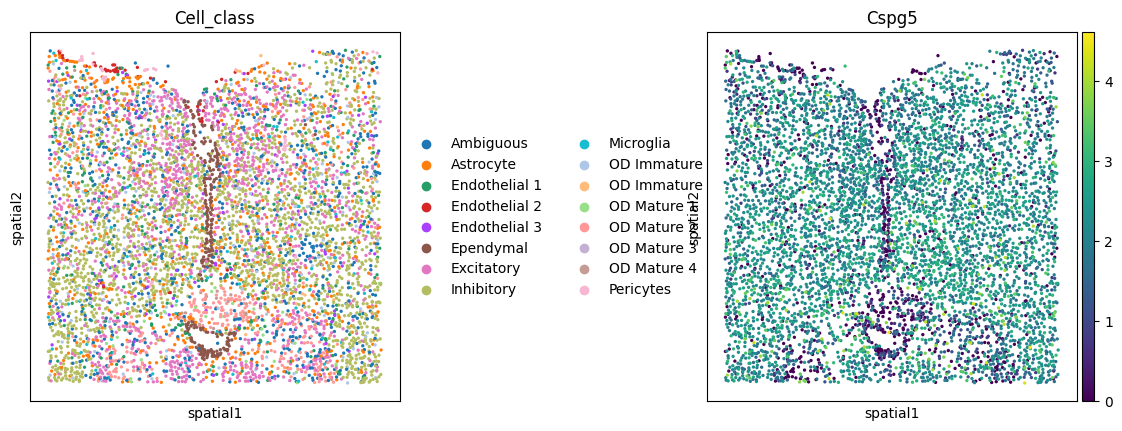

In [5]:
sc.pl.spatial(adata, color=["Cell_class", top_gene], spot_size=0.01)

## Construct spatial cell neighborhood graph

Here we want to connect each node to its k nearest neighbors, while ensuring the graph is undirected

In [6]:
k = 10

coords = adata.obsm["spatial"]
kdtree = scipy.spatial.KDTree(coords)
distances, indices = kdtree.query(coords, k=k + 1, p=2)

In [7]:
print("Indices:\n", indices)
print(f"Indices shape: {indices.shape}")

Indices:
 [[   0   51 5683 ...   39   12   52]
 [   1    8    4 ... 5679   53   46]
 [   2 5679    5 ...   10    8   15]
 ...
 [6103 5615 5668 ... 5644 5675 5619]
 [6104 5676 5630 ... 5616 5628 5634]
 [6105 5605 6101 ... 5581 5518 5598]]
Indices shape: (6106, 11)


In [8]:
edge_index = torch.cat(
    [
        torch.tensor(indices.flatten())[None, :],  # source
        torch.arange(0, coords.shape[0]).repeat_interleave(k + 1)[None, :],  # target
    ],
    axis=0,
)
edge_weight = torch.tensor(distances.flatten()).unsqueeze(-1).to(torch.float32)

In [9]:
edge_index, edge_weight = pyg.utils.to_undirected(edge_index, edge_weight)

In [10]:
print(f"The graph is undirected: {pyg.utils.is_undirected(edge_index)}")

The graph is undirected: True


Lets visualize the graph using networkx

In [11]:
data = Data(edge_index=edge_index, num_nodes=coords.shape[0])
g = pyg.utils.to_networkx(data, to_undirected=True)

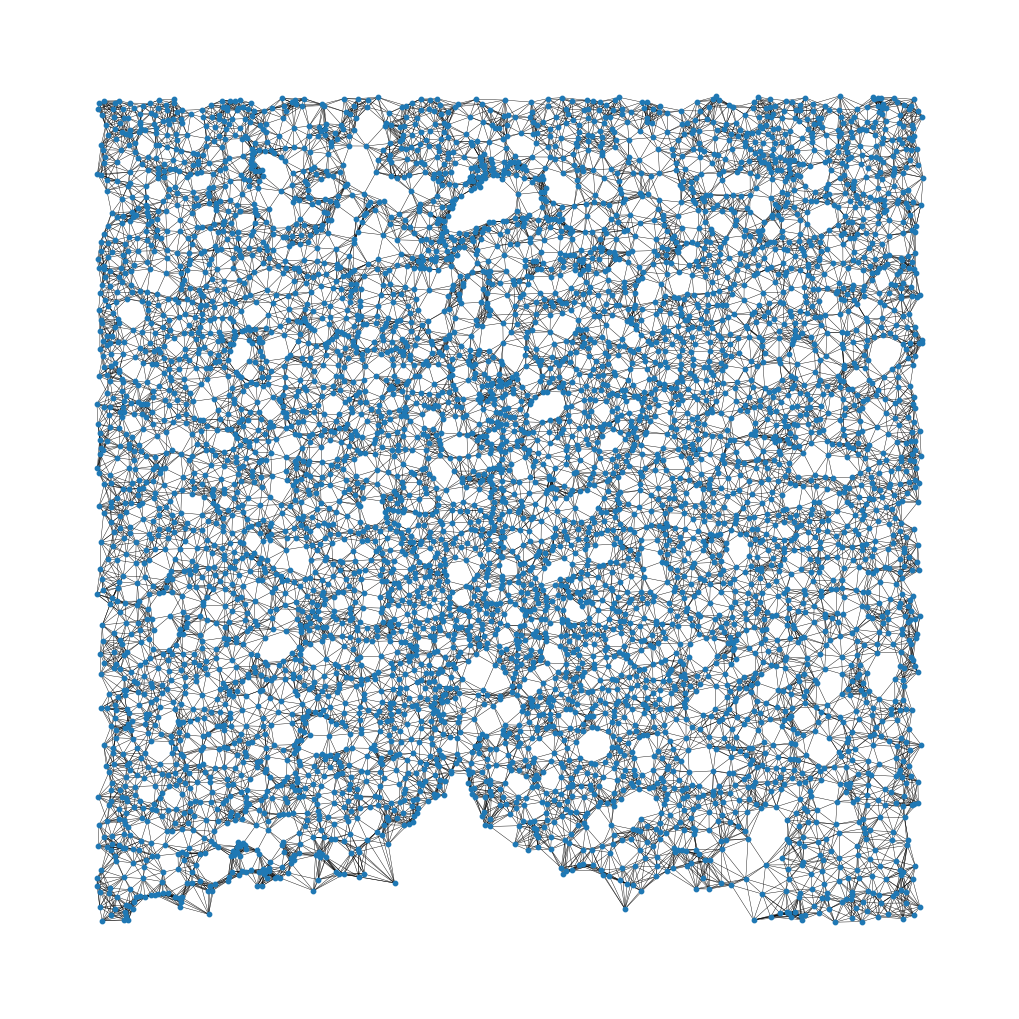

In [12]:
# Remove self-loops for better visualization
g.remove_edges_from(nx.selfloop_edges(g))

plt.figure(figsize=(10, 10))
nx.draw(g, pos=coords, node_size=10, width=0.3)

How would you adapt the code such that cells are only connected to other cell within a defined distance?

## Aggregate expression per neighborhood

This is our target per cell neighborhood

In [13]:
A = pyg.utils.to_scipy_sparse_matrix(edge_index)
A_mean = A / A.sum(axis=1)
X_agg = A_mean @ adata.X

Cell aggregation in the Pytorch Geometric Message Passing Framework

In [32]:
class GraphAggregation(MessagePassing):
    """
    GraphAggregation class for aggregating node features in a graph.

    Args:
        aggr (str): Aggregation method to use. Default is "mean".

    """

    def __init__(self, aggr="mean"):
        super(GraphAggregation, self).__init__(aggr=aggr)

    def forward(self, x, edge_index, **kwargs):
        """
        Forward pass of the GraphAggregation module.

        Args:
            x (Tensor): Node features.
            edge_index (LongTensor): Graph edge indices.

        Returns:
            Tensor: Aggregated node features.

        """
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        """
        Message function for the GraphAggregation module.

        Args:
            x_j (Tensor): Node features of neighboring nodes.

        Returns:
            Tensor: The input node features.

        """
        return x_j

In [15]:
mean_agg = GraphAggregation(aggr="mean")
X = torch.Tensor(adata.X.toarray())
X_agg_pyg = mean_agg(X, edge_index)

In [31]:
print(
    "Results are the same (up to numeric error):",
    np.allclose(X_agg.toarray(), X_agg_pyg.numpy(), atol=1e-9),
)

Results are the same (up to numeric error): True


## Define your own graph convolutional network in Pytorch Geometric

In [17]:
def gcn_norm(edge_index, num_nodes, edge_weight=None, dtype=None):
    """
    Applies graph convolutional network (GCN) normalization to the given edge index and edge weight.

    Args:
        edge_index (Tensor): The edge index tensor of shape (2, num_edges) representing the connectivity of the graph.
        num_nodes (int): The total number of nodes in the graph.
        edge_weight (Tensor, optional): The edge weight tensor of shape (num_edges,) representing the weight of each edge. Defaults to None.
        dtype (torch.dtype, optional): The desired data type of the edge weight tensor. Defaults to None.

    Returns:
        Tuple[Tensor, Tensor]: A tuple containing the updated edge index tensor and the normalized edge weight tensor.

    """
    if edge_weight is None:
        edge_weight = torch.ones(
            (edge_index.size(1),), device=edge_index.device, dtype=dtype
        )

    row, col = edge_index[0], edge_index[1]
    idx = col
    deg = pyg.utils.scatter(edge_weight, idx, dim=0, dim_size=num_nodes, reduce="sum")

    deg_inv_sqrt = deg.pow_(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float("inf"), 0)
    edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    return edge_index, edge_weight

In [18]:
class GCNLayer(MessagePassing):
    """Graph Convolutional Network (GCN) layer implementation.

    This class represents a single layer of a Graph Convolutional Network (GCN).
    It performs message passing and aggregation operations on a graph.

    Args:
        in_channels (int): Number of input channels/features.
        out_channels (int): Number of output channels/features.
        normalize (bool, optional): Whether to normalize the edge weights. Defaults to True.
        aggr (str, optional): Aggregation method for message passing. Defaults to "add".

    Attributes:
        linear (torch.nn.Linear): Linear transformation layer.
        bias (torch.nn.Parameter): Bias parameter.

    """

    def __init__(self, in_channels, out_channels, normalize=True, aggr="add"):
        super(GCNLayer, self).__init__(aggr=aggr)
        self.normalize = normalize

        self.linear = Linear(
            in_channels, out_channels, bias=False, weight_initializer="glorot"
        )
        self.bias = Parameter(torch.zeros(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.linear.reset_parameters()

    def forward(self, x, edge_index, edge_weight=None):
        if self.normalize:
            edge_index, edge_weight = gcn_norm(
                edge_index, x.size(0), edge_weight, dtype=x.dtype
            )

        x = self.linear(x)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight) + self.bias
        return out

    def message(self, x_j, edge_weight=None):
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

In [19]:
# Set the seed for reproducibility
torch.manual_seed(42)

gcn_layer_custom = GCNLayer(adata.X.shape[1], 32)
h_custom = gcn_layer_custom(X_agg_pyg, edge_index)
h_custom

tensor([[ 1.2273,  0.8529, -0.3772,  ...,  0.7987, -0.8296, -1.2554],
        [ 0.5481, -0.1671, -0.6197,  ...,  0.6636, -0.9125, -1.2976],
        [ 0.7186, -0.1014, -0.6908,  ...,  0.6993, -0.9704, -1.2647],
        ...,
        [ 1.1555,  0.8322,  0.7190,  ...,  1.0355, -0.8339, -1.1952],
        [ 1.2136,  0.8151,  0.8227,  ...,  1.0383, -0.7682, -1.0847],
        [ 1.2073,  0.6621,  0.2673,  ...,  1.0520, -0.3292, -1.0725]],
       grad_fn=<AddBackward0>)

### Check that it gives the same result as the built-in GCN implementation

In [20]:
# Set the seed for reproducibility
torch.manual_seed(42)

gcn_layer = GCNConv(adata.X.shape[1], 32, add_self_loops=False)
h = gcn_layer(X_agg_pyg, edge_index)
h

tensor([[ 1.2273,  0.8529, -0.3772,  ...,  0.7987, -0.8296, -1.2554],
        [ 0.5481, -0.1671, -0.6197,  ...,  0.6636, -0.9125, -1.2976],
        [ 0.7186, -0.1014, -0.6908,  ...,  0.6993, -0.9704, -1.2647],
        ...,
        [ 1.1555,  0.8322,  0.7190,  ...,  1.0355, -0.8339, -1.1952],
        [ 1.2136,  0.8151,  0.8227,  ...,  1.0383, -0.7682, -1.0847],
        [ 1.2073,  0.6621,  0.2673,  ...,  1.0520, -0.3292, -1.0725]],
       grad_fn=<AddBackward0>)

In [21]:
print("Results are the same:", torch.allclose(h, h_custom, atol=1e-9))

Results are the same: True


## Bonus: formulate the same architecture in native Pytorch using matrix multiplications

## Define your node-level graph autoencoder

In [22]:
class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, n_layers=2, normalize=True):
        super(GraphEncoder, self).__init__()
        self.linear = Linear(in_channels, hidden_channels)
        self.convs = nn.ModuleList()
        for i in range(n_layers):
            self.convs.append(
                GCNLayer(hidden_channels, hidden_channels, normalize=normalize)
            )

    def forward(self, x, edge_index, edge_weight=None):
        x = self.linear(x)
        for conv in self.convs:
            x = conv(x, edge_index, edge_weight)
            x = torch.relu(x)
        return x

In [23]:
class Decoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, n_layers=2):
        super(Decoder, self).__init__()
        self.mlp = MLP(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            num_layers=n_layers,
            plain_last=False,
        )

    def forward(self, x):
        return self.mlp(x)

In [24]:
class GraphAutoEncoder(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        n_layers_encoder=1,
        n_layers_decoder=1,
        **kwargs,
    ):
        """Initializes a GraphAutoEncoder object.

        Args:
            in_channels (int): Number of input channels.
            hidden_channels (int): Number of hidden channels.
            out_channels (int): Number of output channels.
            n_layers_encoder (int, optional): Number of layers in the encoder. Defaults to 1.
            n_layers_decoder (int, optional): Number of layers in the decoder. Defaults to 1.
            **kwargs: Additional keyword arguments.

        Returns:
            None
        """
        super(GraphAutoEncoder, self).__init__()
        self.encoder = GraphEncoder(
            in_channels, hidden_channels, n_layers=n_layers_encoder, **kwargs
        )
        self.decoder = Decoder(
            hidden_channels, hidden_channels, out_channels, n_layers=n_layers_decoder
        )

    def forward(self, x, edge_index, edge_weight=None):
        h = self.encoder(x, edge_index, edge_weight)
        x = self.decoder(h)
        return x

## Train your model

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"You are using {device}")

You are using cpu


In [26]:
seed = 42
n_epochs = 400
n_genes = adata.X.shape[1]
n_layers_encoder = 1
n_layers_decoder = 1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = GraphAutoEncoder(n_genes, 32, n_genes, n_layers_encoder, n_layers_decoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_agg_pyg, edge_index, edge_weight)
    loss = criterion(out, X_agg_pyg)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.6374402046203613


Epoch 10, Loss: 0.2950449287891388
Epoch 20, Loss: 0.20935040712356567
Epoch 30, Loss: 0.16604217886924744
Epoch 40, Loss: 0.13658775389194489
Epoch 50, Loss: 0.11533760279417038
Epoch 60, Loss: 0.09864431619644165
Epoch 70, Loss: 0.08551502227783203
Epoch 80, Loss: 0.07624238729476929
Epoch 90, Loss: 0.06956086307764053
Epoch 100, Loss: 0.07514108717441559
Epoch 110, Loss: 0.06144440546631813
Epoch 120, Loss: 0.05661617964506149
Epoch 130, Loss: 0.05271707847714424
Epoch 140, Loss: 0.04940762743353844
Epoch 150, Loss: 0.04677998274564743
Epoch 160, Loss: 0.046824436634778976
Epoch 170, Loss: 0.04372984915971756
Epoch 180, Loss: 0.042329005897045135
Epoch 190, Loss: 0.04101002216339111
Epoch 200, Loss: 0.04116614907979965
Epoch 210, Loss: 0.04029916971921921
Epoch 220, Loss: 0.03926556557416916
Epoch 230, Loss: 0.03874459117650986
Epoch 240, Loss: 0.03947265073657036
Epoch 250, Loss: 0.03837723657488823
Epoch 260, Loss: 0.037972234189510345
Epoch 270, Loss: 0.03772016242146492
Epoch 28

## Extract latent embeddings

In [27]:
model.eval()
h = model.encoder(X_agg_pyg, edge_index, edge_weight)
h = h.detach().numpy()

print(f"Encoded features shape: {h.shape}")

Encoded features shape: (6106, 32)


In [28]:
adata.obsm["X_gnn"] = h

## Define spatial domains via Leiden clustering

In [29]:
sc.pp.neighbors(adata, use_rep="X_gnn")
sc.tl.leiden(adata, resolution=0.1)

## Visualize the spatial domains

/miniconda/envs/spacet/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


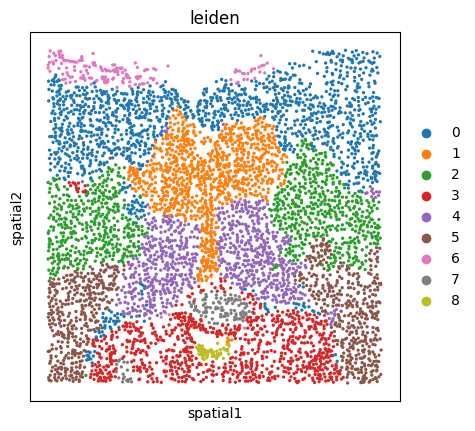

In [30]:
sc.pl.spatial(adata, color="leiden", spot_size=0.01)

## Further references

1. [Geometric deep learning resources](https://geometricdeeplearning.com/)
2. 